In [1]:
import json
from pathlib import Path 
from typing import Tuple, List, Dict
import itertools
from collections import defaultdict

import bella
from bella import parsers
from bella.models.target import TargetDep, TargetDepPlus
from bella.models.tdparse import TDParse, TDParsePlus
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt


import config
import thesis_statistics as thesis_stats

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

Using TensorFlow backend.


# Analysis of the mass evaluation results
## Analysis of the standard datasets
First we look at the mass evaluation on the standard datasets from both the Neural Pooling and LSTM approaches:

In [2]:
def load_np_results(save_dir: Path, dataset_name: str, model_name: str
                    ) -> np.ndarray:
    model_save_dir = Path(save_dir, model_name)
    save_file = Path(model_save_dir, f'{dataset_name}.npy')
    return np.load(save_file)

def np_accuracy_f1_score(save_dir: Path, 
                         test_dataset: bella.data_types.TargetCollection,
                         model_name: str) -> Tuple[float, float]:
    predictions = load_np_results(save_dir, test_dataset.name, model_name)
    f1_result = f1_score(test_dataset.sentiment_data(), predictions, average='macro')
    accuracy_result = accuracy_score(test_dataset.sentiment_data(), predictions)
    return accuracy_result, f1_result

def get_sig_better_worse_models(bootstrap_scores: List[np.ndarray], model_names: List[str]
                                ) -> pd.DataFrame:
    '''
    a list of output from thesis_stats.bootstrap
    returns the number of times each model is better than the other models for each 
    dataset.
    '''
    metric_better_worse_p_value = defaultdict(lambda: defaultdict(lambda: list()))
    for bootstrap_score in bootstrap_scores:
        metric_p_values = thesis_stats.bootstrap_one_t_test(bootstrap_score, 
                                                            model_names)
        for better_model_name in bootstrap_model_names:
            for worse_model_name in bootstrap_model_names:
                metric_better_worse_p_value[better_model_name][worse_model_name].append(metric_p_values[better_model_name][worse_model_name])
    metric_better_worse_dataset_count = defaultdict(lambda: dict())
    for better_model_name in bootstrap_model_names:
        for worse_model_name in bootstrap_model_names:
            number_datasets = thesis_stats.find_k_estimator(metric_better_worse_p_value[better_model_name][worse_model_name], 
                                                            alpha=0.05)
            metric_better_worse_dataset_count[better_model_name][worse_model_name] = number_datasets
    return pd.DataFrame(metric_better_worse_dataset_count)

# Load the test datasets for the analysis on the neural pooling approaches
restaurant_test = parsers.semeval_14(config.restaurant_test, name='Restaurant')
laptop_test = parsers.semeval_14(config.laptop_test, name='Laptop')
dong_test = parsers.dong(config.DONG_TEST, name='Dong')
mitchell_test = parsers.semeval_14(config.mitchell_test, name='Mitchell')
youtubean_test = parsers.semeval_14(config.youtubean_test, name='YouTuBean')
election_test = parsers.election_test(config.ELECTION, name='Election')
np_test_datasets = [restaurant_test, laptop_test, dong_test, mitchell_test,
                    election_test, youtubean_test]
# State where the results were stored for the NP approaches
np_result_dir = config.RESULTS_DIR / 'Mass Evaluation'
np_models = [TargetDep, TargetDepPlus, TDParse, TDParsePlus]
np_model_names = [model.name() for model in np_models]

# Load the results for the NP approaches
result_dataset_names = []
result_model_names = []
result_accuracies = []
result_f1s = []

# Array in each list should be of shape (n_samples)
np_true_values: List[np.ndarray] = []
# Array in each list should be of shape (n_samples, n_models)
np_predictions: List[np.ndarray] = []

for dataset_index, np_dataset in enumerate(np_test_datasets):
    model_predictions = []
    for model_name in np_model_names:
        model_accuracy, model_f1 = np_accuracy_f1_score(np_result_dir, 
                                                        np_dataset, model_name)
        result_f1s.append(model_f1)
        result_accuracies.append(model_accuracy)
        result_model_names.append(model_name)
        result_dataset_names.append(np_dataset.name)
        model_predictions.append(load_np_results(np_result_dir, 
                                                 np_dataset.name,
                                                 model_name))
        if len(np_true_values) == dataset_index:
            np_true_values.append(np.array(np_dataset.sentiment_data()))
    model_predictions = np.array(model_predictions).T
    np_predictions.append(model_predictions)

Above loads the NP method results and below loads the LSTM method results:

In [22]:
def load_lstm_results(save_dir: Path, dataset_name: str, model_name: str,
                      value_mapper: Dict[str, int],
                      test_results: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Shape of the first numpy array will be (n_samples)
    Shape of the second numpy array will be (n_sample, n_runs)
    '''
    result_fp = save_dir / f'{model_name}' / f'{dataset_name} test.json'
    if not test_results:
        result_fp = save_dir / f'{model_name}' / f'{dataset_name} validation.json'
    results = None
    with result_fp.open('r') as result_file:
        results = json.load(result_file)
    assert results is not None
    true_values, run_prediction_values = results
    true_values = np.array([value_mapper[value] for value in true_values])
    run_prediction_values = [[value_mapper[prediction] 
                              for prediction in predictions] 
                              for predictions in run_prediction_values]
    return np.array(true_values), np.array(run_prediction_values).T

def get_lstm_score(true_values: np.ndarray, run_predictions: np.ndarray, 
                   metric, **metric_kwargs) -> np.ndarray:
    '''
    A nupy array of shape (number of model runs)
    '''
    num_runs = run_predictions.shape[1]
    scores = []
    for run in range(num_runs):
        scores.append(metric(true_values, run_predictions[:, run], 
                      **metric_kwargs))
    return np.array(scores)

# State where the results were stored for the LSTM approaches
lstm_result_dir = config.RESULTS_DIR / 'Mass Evaluation' / 'patience 10'
lstm_dataset_names = [dataset.name for dataset in np_test_datasets]
lstm_model_names = ['LSTM', 'TDLSTM', 'TCLSTM']
# Maps string values to integers for the sklearn tools to get
# metrics
lstm_label_mapper = {'positive': 2, 'negative': 1, 'neutral': 3}

# Array in each list should be of shape (n_samples)
lstm_true_values: List[np.ndarray] = []
# Array in each list should be of shape (n_samples, n_models)
lstm_predictions: List[np.ndarray] = []
max_lstm_predictions: List[np.ndarray] = []
max_f1_lstm_predictions: List[np.ndarray] = []

lstm_validation_dataset_names = []
lstm_validation_model_names = []
lstm_validation_accuracies = []
lstm_validation_f1s = []

for dataset_index, dataset_name in enumerate(lstm_dataset_names):
    lstm_model_predictions = []
    lstm_max_model_predictions = []
    lstm_f1_max_model_predictions = []
    for lstm_model_name in lstm_model_names:
        result_values = load_lstm_results(lstm_result_dir,
                                          dataset_name, lstm_model_name, 
                                          lstm_label_mapper, test_results=True)
        
        model_accuracies = get_lstm_score(result_values[0], result_values[1],
                                           accuracy_score)
        model_f1s = get_lstm_score(result_values[0], result_values[1],
                                   f1_score, average='macro') 
        for model_score_index, model_accuracy in enumerate(model_accuracies):
            model_f1 = model_f1s[model_score_index]
            
            result_dataset_names.append(dataset_name)
            result_model_names.append(lstm_model_name)
            result_accuracies.append(model_accuracy)
            result_f1s.append(model_f1)
        median_model_run_index = np.argsort(model_accuracies)[len(model_accuracies) // 2]
        max_model_run_index = np.argmax(model_accuracies)
        max_f1_model_run_index = np.argmax(model_f1s)

        if dataset_index == len(lstm_true_values):
            lstm_true_values.append(result_values[0])
        lstm_model_predictions.append(result_values[1][:,median_model_run_index])
        lstm_max_model_predictions.append(result_values[1][:,max_model_run_index])
        lstm_f1_max_model_predictions.append(result_values[1][:,max_f1_model_run_index])

        # Getting and storing the validation results
        validation_result_values = load_lstm_results(lstm_result_dir,
                                                     dataset_name, lstm_model_name, 
                                                     lstm_label_mapper, test_results=False)
        validation_model_accuracies = get_lstm_score(validation_result_values[0], 
                                                     validation_result_values[1],
                                                     accuracy_score)
        validation_model_f1s = get_lstm_score(validation_result_values[0], 
                                              validation_result_values[1],
                                              f1_score, average='macro') 
        for model_score_index, model_accuracy in enumerate(validation_model_accuracies):
            model_f1 = validation_model_f1s[model_score_index]
            
            lstm_validation_dataset_names.append(dataset_name)
            lstm_validation_model_names.append(lstm_model_name)
            lstm_validation_accuracies.append(model_accuracy)
            lstm_validation_f1s.append(model_f1)
    lstm_model_predictions = np.array(lstm_model_predictions).T
    lstm_predictions.append(lstm_model_predictions)
    lstm_max_model_predictions = np.array(lstm_max_model_predictions).T
    max_lstm_predictions.append(lstm_max_model_predictions)
    lstm_f1_max_model_predictions = np.array(lstm_f1_max_model_predictions).T
    max_f1_lstm_predictions.append(lstm_f1_max_model_predictions)
        
    


After loading both sets of results we can see below the accuracy results and below that the Macro F1 results:

In [4]:
model_order = lstm_model_names + np_model_names
accuracy_index_order = list(itertools.product(['Accuracy'], model_order))

result_df = pd.DataFrame({'Model': result_model_names,
                          'Dataset': result_dataset_names,
                          'Accuracy': result_accuracies,
                          'F1': result_f1s})
accuracy_result_df = (pd.pivot_table(data=result_df, 
                                     values=['Accuracy'], 
                                     index='Dataset', 
                                     columns='Model', 
                                     aggfunc=np.mean)*100).round(2).T
result_averages = result_df.groupby(['Model', 'Dataset']).mean()\
                           .groupby('Model').mean()
dataset_averages = result_df.groupby(['Model', 'Dataset']).mean()\
                           .groupby('Dataset').mean()
result_averages = result_averages.reindex(model_order)
accuracy_result_df = accuracy_result_df.reindex(accuracy_index_order)
# Add the mean column
accuracy_result_averages = (result_averages['Accuracy'] * 100)
accuracy_result_averages.index = pd.MultiIndex.from_tuples(accuracy_index_order)
accuracy_result_df['Mean'] = accuracy_result_averages
accuracy_result_df.round(2)


Dataset                          Dong  Election  Laptop  Mitchell  Restaurant  \
         Model                                                                  
Accuracy LSTM                   64.57     47.85   59.90     71.04       68.63   
         TDLSTM                 71.12     57.50   61.76     70.52       73.56   
         TCLSTM                 68.98     57.40   56.77     70.77       71.85   
         Target Dependent       68.50     57.22   66.14     73.45       77.32   
         Target Dependent Plus  70.23     53.21   68.97     74.37       78.04   
         TDParse                67.77     57.46   67.08     73.96       77.95   
         TDParsePlus            69.36     56.12   68.50     73.35       78.30   

Dataset                         YouTuBean   Mean  
         Model                                    
Accuracy LSTM                       63.33  62.55  
         TDLSTM                     64.17  66.44  
         TCLSTM                     66.81  65.43  
         Target Dependent           82.50  70.86  
         Target Dependent Plus      81.67  71.08  
         TDParse                    79.58  70.63  
         TDParsePlus                83.33  71.49

In [10]:
f1_index_order = list(itertools.product(['F1'], model_order))
f1_result_df = (pd.pivot_table(data=result_df, 
                               values=['F1'], 
                               index='Dataset', 
                               columns='Model', 
                               aggfunc=np.mean)*100).round(2).T
f1_result_df = f1_result_df.reindex(f1_index_order)
# Add the mean column
f1_result_averages = (result_averages['F1'] * 100).round(2)
f1_result_averages.index = pd.MultiIndex.from_tuples(f1_index_order)
f1_result_df['Mean'] = f1_result_averages
f1_result_df

Dataset                    Dong  Election  Laptop  Mitchell  Restaurant  \
   Model                                                                  
F1 LSTM                   61.58     30.65   41.91     35.51       37.15   
   TDLSTM                 68.54     42.54   49.82     29.67       56.66   
   TCLSTM                 65.92     43.57   45.04     38.42       53.54   
   Target Dependent       65.27     46.60   57.86     48.98       63.17   
   Target Dependent Plus  67.36     44.52   62.33     48.08       64.44   
   TDParse                64.33     46.64   59.23     48.58       64.66   
   TDParsePlus            66.36     46.30   61.89     51.17       65.26   

Dataset                   YouTuBean   Mean  
   Model                                    
F1 LSTM                       25.85  38.78  
   TDLSTM                     28.98  46.04  
   TCLSTM                     36.83  47.22  
   Target Dependent           74.80  59.45  
   Target Dependent Plus      72.90  59.94  
   TDParse                    70.05  58.91  
   TDParsePlus                74.46  60.91

As can be seen from the results above their is a large difference between the NP and the LSTM approaches espically for the Macro F1 results. As the LSTM approaches have been ran multiple times below we create the violin plots showing the range of results created from each model on each dataset for each metric.

Accuracy:




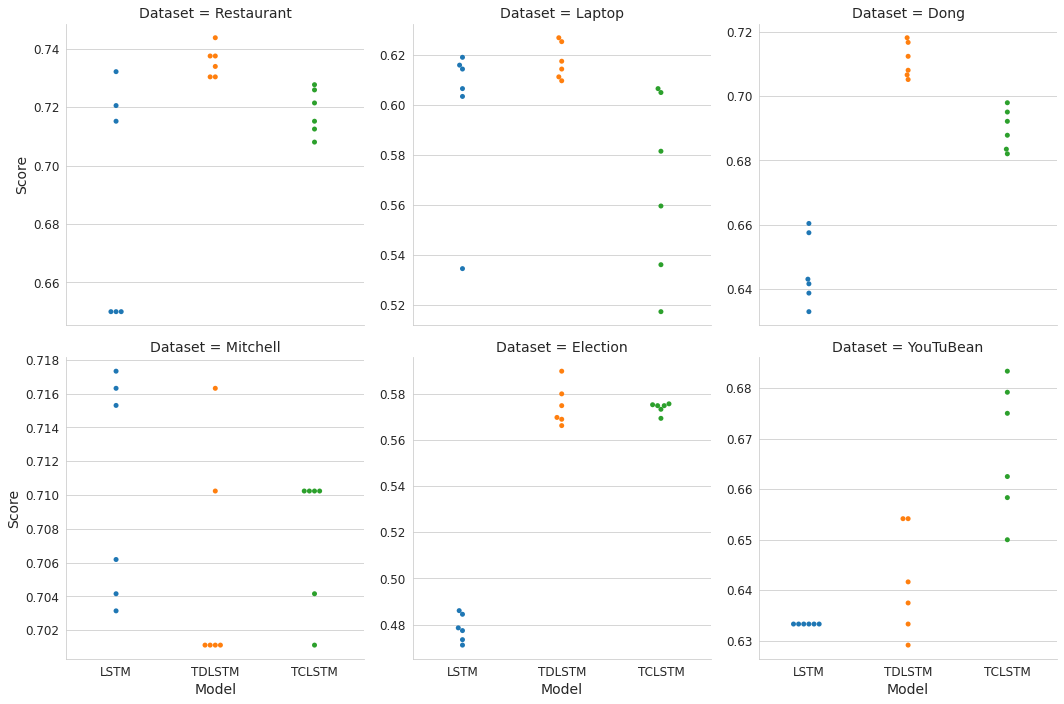

In [34]:
image_dir = config.IMAGES_DIR / 'Mass Evaluation'
image_dir.mkdir(parents=True, exist_ok=True)
a4_dims = (11.7, 8.27)
lstm_results_df = result_df.copy(deep=True)
lstm_results_df = lstm_results_df[lstm_results_df['Model'].isin(lstm_model_names)]
lstm_results_df = pd.melt(lstm_results_df, id_vars=['Dataset', 'Model'], 
                          value_vars=['Accuracy', 'F1'], var_name='Metric', 
                          value_name='Score')
lstm_results_df_acc = lstm_results_df[lstm_results_df['Metric']=='Accuracy']
lstm_test_ax = sns.catplot(x='Model', y='Score', kind='swarm',
                           col='Dataset', data=lstm_results_df_acc, 
                           sharey=False, col_wrap=3) 
image_fp = str(Path(image_dir, 'LSTM_Test_ACC.pdf').resolve())
lstm_test_ax.savefig(image_fp, bbox_inches='tight')
lstm_test_ax

Macro F1:

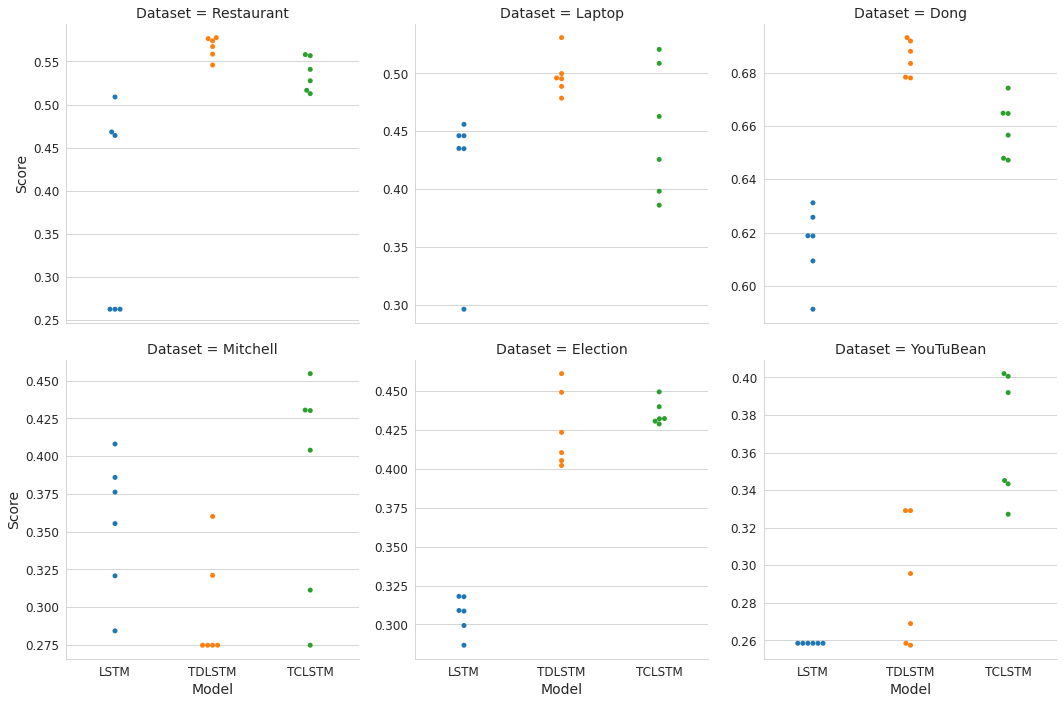

In [35]:
lstm_results_df_f1 = lstm_results_df[lstm_results_df['Metric']=='F1']
lstm_test_ax = sns.catplot(x='Model', y='Score', kind='swarm',
                           col='Dataset', data=lstm_results_df_f1, 
                           sharey=False, col_wrap=3) 
image_fp = str(Path(image_dir, 'LSTM_Test_F1.pdf').resolve())
lstm_test_ax.savefig(image_fp, bbox_inches='tight')
lstm_test_ax

As we can see from above the shape of the plots are similar no matter the metric, but it is clear to see that the results can vary a lot depending on the random seed.

Below are the significant difference tables between the approaches. The first table is for the accuracy metric and the second is for the Macro F1 metric. For the LSTM approaches as they have been ran multiple times we use the Median best peformance for the bootstrapping.

In [7]:
# Finding mapping between the np and lstm true values

mapped_lstm_true_values = []
mapped_lstm_predictions = []
for true_values_index, true_values in enumerate(np_true_values):
    true_values = np.array(true_values)
    np_mapped_values = np.unique(true_values).tolist()
    
    lstm_to_np_mapper = {}
    lstm_values = lstm_true_values[true_values_index].tolist()
    for np_mapped_value in np_mapped_values:
        lstm_to_np_mapper[lstm_values[true_values.tolist().index(np_mapped_value)]] = np_mapped_value
    
    mapped_lstm_true_values.append(np.array([lstm_to_np_mapper[value] for value in lstm_values]))
    mapped_model_predictions = []
    for model_predictions in lstm_predictions[true_values_index].T.tolist():
        mapped_model_predictions.append([lstm_to_np_mapper[value] for value in model_predictions])
    mapped_lstm_predictions.append(np.array(mapped_model_predictions).T)

# Join the NP and LSTM predictions together
all_predictions = []
for prediction_index, np_prediction in enumerate(np_predictions):
    all_predictions.append(np.concatenate([np_prediction, 
                                           mapped_lstm_predictions[prediction_index]], 1))

# Get the bootstrap values for each dataset for each model
# The arrays are of shape (number_bootstraps, number models)
accuracy_bootstrap: List[np.ndarray] = []
f1_bootstrap: List[np.ndarray] = []
for dataset_index, _ in enumerate(np_test_datasets):
    true_values = np_true_values[dataset_index]
    predictions = all_predictions[dataset_index]
    
    accuracy_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                                     predictions, 
                                                     accuracy_score))
    f1_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                               predictions, 
                                               f1_score, 
                                               average='macro'))

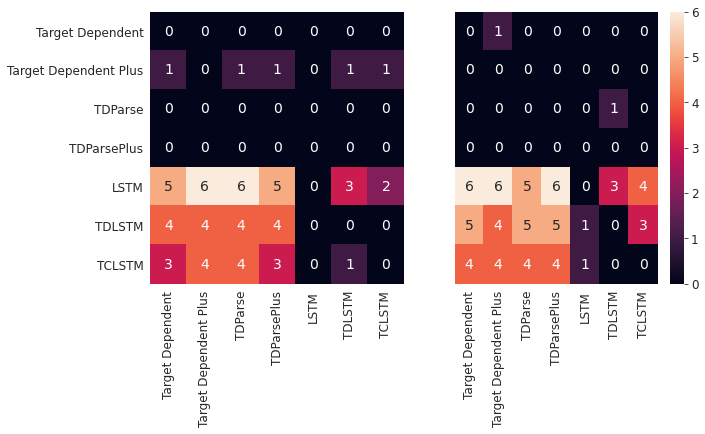

In [8]:
bootstrap_model_names = np_model_names + lstm_model_names
fig, sig_test_axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
sns.heatmap(get_sig_better_worse_models(accuracy_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[0], cbar=False)
sns.heatmap(get_sig_better_worse_models(f1_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[1])
image_fp = str(Path(image_dir, 'Sig_Test.pdf').resolve())
fig.savefig(image_fp, bbox_inches='tight')

As we can see for the accuracy and macro F1 results left and right above the NP methods are Significantly better than the LSTM approaches (columns are compared to the rows). Further the baseline non-target approach that is the LSTM is significantly worse than all of the target aware approach which is expected.

Below we show what happens when the LSTM methods only use their maximum random seed score for the accuracy and macro F1 metric

In [9]:
max_accuracy_result_df = (pd.pivot_table(data=result_df, 
                                         values=['Accuracy'], 
                                         index='Dataset', 
                                         columns='Model', 
                                         aggfunc=np.max)*100).round(2).T
max_result_averages = result_df.groupby(['Model', 'Dataset']).max()\
                               .groupby('Model').mean()
max_dataset_averages = result_df.groupby(['Model', 'Dataset']).max()\
                                .groupby('Dataset').mean()
max_result_averages = max_result_averages.reindex(model_order)
max_accuracy_result_df = max_accuracy_result_df.reindex(accuracy_index_order)
# Add the mean column
max_accuracy_result_averages = (max_result_averages['Accuracy'] * 100)
max_accuracy_result_averages.index = pd.MultiIndex.from_tuples(accuracy_index_order)
max_accuracy_result_df['Mean'] = max_accuracy_result_averages
max_accuracy_result_df.round(2)


Dataset                          Dong  Election  Laptop  Mitchell  Restaurant  \
         Model                                                                  
Accuracy LSTM                   66.04     48.60   61.91     71.73       73.21   
         TDLSTM                 71.82     58.99   62.70     71.63       74.38   
         TCLSTM                 69.80     57.58   60.66     71.02       72.77   
         Target Dependent       68.50     57.22   66.14     73.45       77.32   
         Target Dependent Plus  70.23     53.21   68.97     74.37       78.04   
         TDParse                67.77     57.46   67.08     73.96       77.95   
         TDParsePlus            69.36     56.12   68.50     73.35       78.30   

Dataset                         YouTuBean   Mean  
         Model                                    
Accuracy LSTM                       63.33  64.14  
         TDLSTM                     65.42  67.49  
         TCLSTM                     68.33  66.69  
         Target Dependent           82.50  70.86  
         Target Dependent Plus      81.67  71.08  
         TDParse                    79.58  70.63  
         TDParsePlus                83.33  71.49

In [10]:

max_f1_result_df = (pd.pivot_table(data=result_df, 
                                   values=['F1'], 
                                   index='Dataset', 
                                   columns='Model', 
                                   aggfunc=np.max)*100).round(2).T
max_f1_result_df = max_f1_result_df.reindex(f1_index_order)
# Add the mean column
max_f1_result_averages = (max_result_averages['F1'] * 100).round(2)
max_f1_result_averages.index = pd.MultiIndex.from_tuples(f1_index_order)
max_f1_result_df['Mean'] = max_f1_result_averages
max_f1_result_df

Dataset                    Dong  Election  Laptop  Mitchell  Restaurant  \
   Model                                                                  
F1 LSTM                   63.11     31.81   45.60     40.81       50.87   
   TDLSTM                 69.31     46.13   53.09     36.01       57.76   
   TCLSTM                 67.42     44.96   52.07     45.47       55.79   
   Target Dependent       65.27     46.60   57.86     48.98       63.17   
   Target Dependent Plus  67.36     44.52   62.33     48.08       64.44   
   TDParse                64.33     46.64   59.23     48.58       64.66   
   TDParsePlus            66.36     46.30   61.89     51.17       65.26   

Dataset                   YouTuBean   Mean  
   Model                                    
F1 LSTM                       25.85  43.01  
   TDLSTM                     32.91  49.20  
   TCLSTM                     40.20  50.98  
   Target Dependent           74.80  59.45  
   Target Dependent Plus      72.90  59.94  
   TDParse                    70.05  58.91  
   TDParsePlus                74.46  60.91

Showing the significant differences between the methods when the LSTM methods use the best random seed for the accuracy metric:

In [25]:
# Finding mapping between the np and lstm true values

mapped_lstm_true_values = []
mapped_lstm_predictions = []
for true_values_index, true_values in enumerate(np_true_values):
    true_values = np.array(true_values)
    np_mapped_values = np.unique(true_values).tolist()
    
    lstm_to_np_mapper = {}
    lstm_values = lstm_true_values[true_values_index].tolist()
    for np_mapped_value in np_mapped_values:
        lstm_to_np_mapper[lstm_values[true_values.tolist().index(np_mapped_value)]] = np_mapped_value
    
    mapped_lstm_true_values.append(np.array([lstm_to_np_mapper[value] for value in lstm_values]))
    mapped_model_predictions = []
    for model_predictions in max_lstm_predictions[true_values_index].T.tolist():
        mapped_model_predictions.append([lstm_to_np_mapper[value] for value in model_predictions])
    mapped_lstm_predictions.append(np.array(mapped_model_predictions).T)

# Join the NP and LSTM predictions together
all_predictions = []
for prediction_index, np_prediction in enumerate(np_predictions):
    all_predictions.append(np.concatenate([np_prediction, 
                                           mapped_lstm_predictions[prediction_index]], 1))

# Get the bootstrap values for each dataset for each model
# The arrays are of shape (number_bootstraps, number models)
accuracy_bootstrap: List[np.ndarray] = []
f1_bootstrap: List[np.ndarray] = []
for dataset_index, _ in enumerate(np_test_datasets):
    true_values = np_true_values[dataset_index]
    predictions = all_predictions[dataset_index]
    
    accuracy_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                                     predictions, 
                                                     accuracy_score))
    f1_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                               predictions, 
                                               f1_score, 
                                               average='macro'))

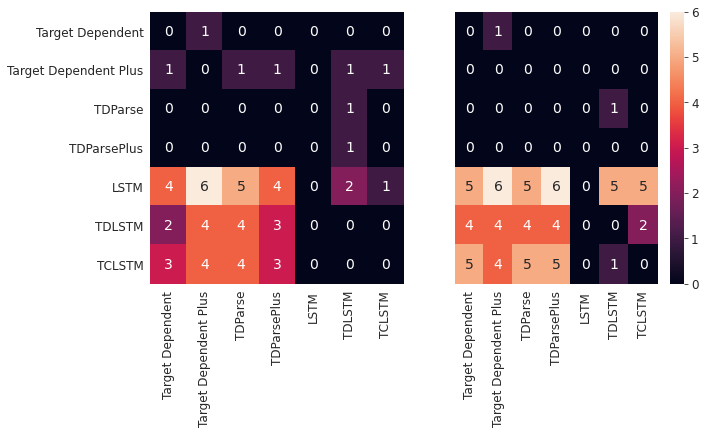

In [26]:
bootstrap_model_names = np_model_names + lstm_model_names
fig, sig_test_axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
sns.heatmap(get_sig_better_worse_models(accuracy_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[0], cbar=False)
sns.heatmap(get_sig_better_worse_models(f1_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[1])
image_fp = str(Path(image_dir, 'Sig_Max_Acc_Test.pdf').resolve())
fig.savefig(image_fp, bbox_inches='tight')

And the best random seed for the macro F1 metric:

In [23]:
# Finding mapping between the np and lstm true values

mapped_lstm_true_values = []
mapped_lstm_predictions = []
for true_values_index, true_values in enumerate(np_true_values):
    true_values = np.array(true_values)
    np_mapped_values = np.unique(true_values).tolist()
    
    lstm_to_np_mapper = {}
    lstm_values = lstm_true_values[true_values_index].tolist()
    for np_mapped_value in np_mapped_values:
        lstm_to_np_mapper[lstm_values[true_values.tolist().index(np_mapped_value)]] = np_mapped_value
    
    mapped_lstm_true_values.append(np.array([lstm_to_np_mapper[value] for value in lstm_values]))
    mapped_model_predictions = []
    for model_predictions in max_f1_lstm_predictions[true_values_index].T.tolist():
        mapped_model_predictions.append([lstm_to_np_mapper[value] for value in model_predictions])
    mapped_lstm_predictions.append(np.array(mapped_model_predictions).T)

# Join the NP and LSTM predictions together
all_predictions = []
for prediction_index, np_prediction in enumerate(np_predictions):
    all_predictions.append(np.concatenate([np_prediction, 
                                           mapped_lstm_predictions[prediction_index]], 1))

# Get the bootstrap values for each dataset for each model
# The arrays are of shape (number_bootstraps, number models)
accuracy_bootstrap: List[np.ndarray] = []
f1_bootstrap: List[np.ndarray] = []
for dataset_index, _ in enumerate(np_test_datasets):
    true_values = np_true_values[dataset_index]
    predictions = all_predictions[dataset_index]
    
    accuracy_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                                     predictions, 
                                                     accuracy_score))
    f1_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                               predictions, 
                                               f1_score, 
                                               average='macro'))

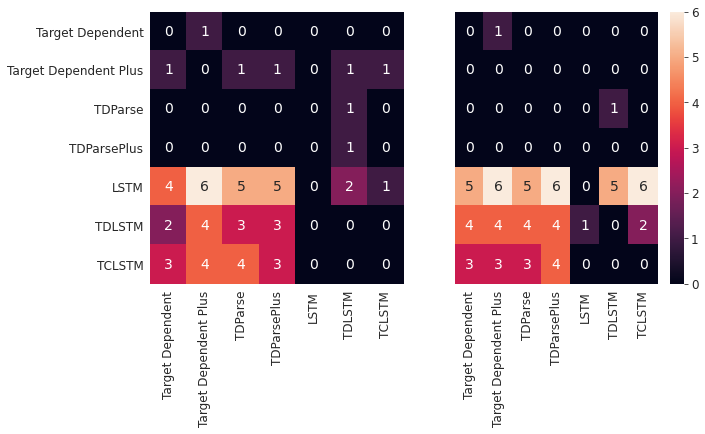

In [24]:
bootstrap_model_names = np_model_names + lstm_model_names
fig, sig_test_axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
sns.heatmap(get_sig_better_worse_models(accuracy_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[0], cbar=False)
sns.heatmap(get_sig_better_worse_models(f1_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[1])
image_fp = str(Path(image_dir, 'Sig_Max_F1_Test.pdf').resolve())
fig.savefig(image_fp, bbox_inches='tight')



### Validation scores for the LSTM models
For completeness the scores from the validation data are shown below. This is only applicable for the LSTM models as the NP models use the whole training data and do not require validation data.

Accuracy results:

In [36]:
accuracy_index_order = list(itertools.product(['Accuracy'], lstm_model_names))
validation_result_df = pd.DataFrame({'Model': lstm_validation_model_names,
                                     'Dataset': lstm_validation_dataset_names,
                                     'Accuracy': lstm_validation_accuracies,
                                     'F1': lstm_validation_f1s})
accuracy_result_df = (pd.pivot_table(data=validation_result_df, 
                                     values=['Accuracy'], 
                                     index='Dataset', 
                                     columns='Model', 
                                     aggfunc=np.mean)*100).round(2).T
result_averages = validation_result_df.groupby(['Model', 'Dataset']).mean()\
                                      .groupby('Model').mean()
result_averages = result_averages.reindex(lstm_model_names)
accuracy_result_df = accuracy_result_df.reindex(accuracy_index_order)
# Add the mean column
accuracy_result_averages = (result_averages['Accuracy'] * 100).round(2)
accuracy_result_averages.index = pd.MultiIndex.from_tuples(accuracy_index_order)
accuracy_result_df['Mean'] = accuracy_result_averages
accuracy_result_df


Dataset           Dong  Election  Laptop  Mitchell  Restaurant  YouTuBean  \
         Model                                                              
Accuracy LSTM    62.61     49.19   63.97     70.61       64.10      63.79   
         TDLSTM  68.47     57.95   66.24     70.28       70.09      65.52   
         TCLSTM  68.84     57.35   62.48     70.91       67.23      70.55   

Dataset           Mean  
         Model          
Accuracy LSTM    62.38  
         TDLSTM  66.43  
         TCLSTM  66.23

F1 results:

In [37]:
f1_index_order = list(itertools.product(['F1'], lstm_model_names))
f1_result_df = (pd.pivot_table(data=validation_result_df, 
                               values=['F1'], 
                               index='Dataset', 
                               columns='Model', 
                               aggfunc=np.mean)*100).round(2).T
f1_result_df = f1_result_df.reindex(f1_index_order)
# Add the mean column
f1_result_averages = (result_averages['F1'] * 100).round(2)
f1_result_averages.index = pd.MultiIndex.from_tuples(f1_index_order)
f1_result_df['Mean'] = f1_result_averages
f1_result_df

Dataset     Dong  Election  Laptop  Mitchell  Restaurant  YouTuBean   Mean
   Model                                                                  
F1 LSTM    60.11     30.53   46.69     35.69       36.44      25.96  39.24
   TDLSTM  65.53     42.89   54.84     29.80       59.10      30.60  47.13
   TCLSTM  64.98     43.42   52.87     40.20       55.10      41.42  49.66

Distribution of results plot

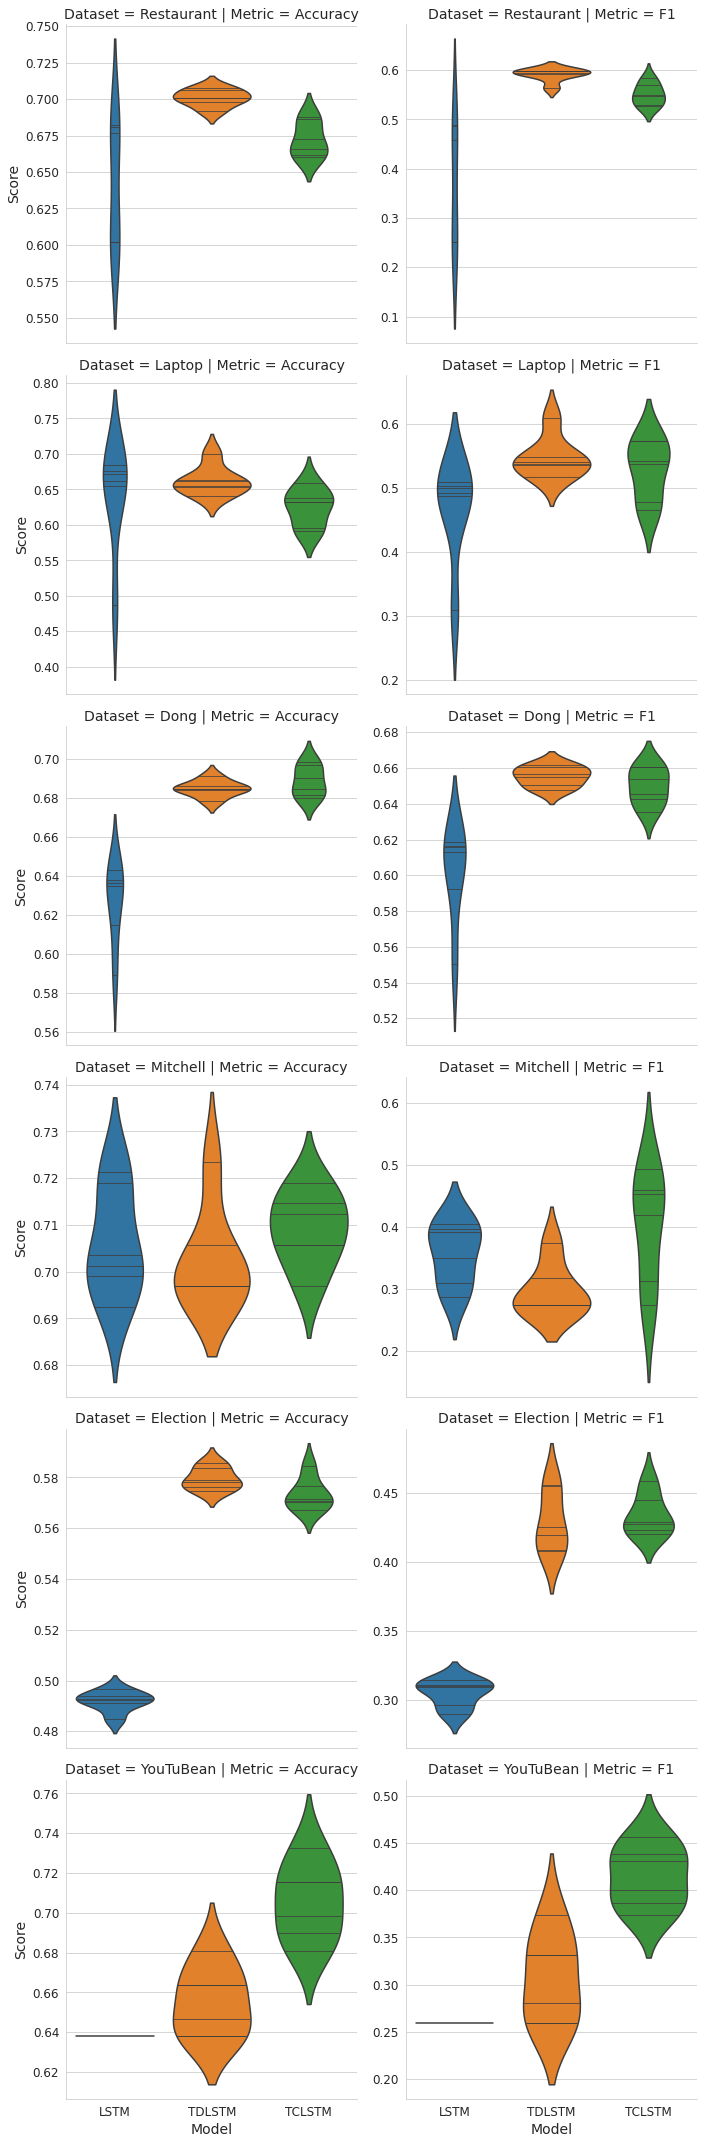

In [38]:
image_dir = config.IMAGES_DIR / 'Mass Evaluation'
image_dir.mkdir(parents=True, exist_ok=True)

lstm_results_df = pd.melt(validation_result_df, id_vars=['Dataset', 'Model'], 
                          value_vars=['Accuracy', 'F1'], var_name='Metric', 
                          value_name='Score')
lstm_test_ax = sns.catplot(x='Model', y='Score',  inner='stick',
                           col='Metric', data=lstm_results_df, 
                           kind='violin', row='Dataset', 
                           sharey=False) 
image_fp = str(Path(image_dir, 'LSTM_Validation_ACC_F1.pdf').resolve())
lstm_test_ax.savefig(image_fp, bbox_inches='tight')
lstm_test_ax

## Analysis of the smaller datasets

These are models that have been trained on data that contains only 558 targets, which is the same training set size as the YouTuBean. They are evaluated on the same test datasets. The validation sets used by the LSTM models are 20% of the small training sets ($\approx 111$ targets), thus making their training size $\approx 447$ targets.

In [47]:
def f1_by_labelscore(save_dir: Path, 
                     test_dataset: bella.data_types.TargetCollection,
                     model_name: str) -> Tuple[float, float, float]:
    predictions = load_np_results(save_dir, test_dataset.name, model_name)
    negative_f1 = f1_score(test_dataset.sentiment_data(), predictions, 
                           average='macro', labels=[-1])
    negative_f1 = f1_score(test_dataset.sentiment_data(), predictions, 
                           average='macro', labels=[-1])
    neutral_f1 = f1_score(test_dataset.sentiment_data(), predictions, 
                           average='macro', labels=[0])
    positive_f1 = f1_score(test_dataset.sentiment_data(), predictions, 
                           average='macro', labels=[1])
    accuracy_result = accuracy_score(test_dataset.sentiment_data(), predictions)
    return negative_f1, neutral_f1, positive_f1

# State where the results were stored for the NP approaches
np_small_result_dir = config.RESULTS_DIR / 'Mass Evaluation Small Dataset'
np_models = [TargetDep, TargetDepPlus, TDParse, TDParsePlus]
np_model_names = [model.name() for model in np_models]

# Load the results for the NP approaches
result_dataset_names = []
result_model_names = []
result_accuracies = []
result_f1s = []
result_negative_f1s = []
result_neutral_f1s = []
result_positive_f1s = []

# Array in each list should be of shape (n_samples)
np_true_values: List[np.ndarray] = []
# Array in each list should be of shape (n_samples, n_models)
np_predictions: List[np.ndarray] = []

for dataset_index, np_dataset in enumerate(np_test_datasets):
    if np_dataset.name == 'YouTuBean':
        continue
    model_predictions = []
    for model_name in np_model_names:
        model_accuracy, model_f1 = np_accuracy_f1_score(np_small_result_dir, 
                                                        np_dataset, model_name)
        result_f1s.append(model_f1)
        result_accuracies.append(model_accuracy)
        result_model_names.append(model_name)
        result_dataset_names.append(np_dataset.name)
        neg, neu, pos = f1_by_labelscore(np_small_result_dir, np_dataset, model_name)
        result_negative_f1s.append(neg)
        result_neutral_f1s.append(neu)
        result_positive_f1s.append(pos)
        
        model_predictions.append(load_np_results(np_small_result_dir, 
                                                 np_dataset.name,
                                                 model_name))
        if len(np_true_values) == dataset_index:
            np_true_values.append(np.array(np_dataset.sentiment_data()))
    model_predictions = np.array(model_predictions).T
    np_predictions.append(model_predictions)

In [48]:
# State where the results were stored for the LSTM approaches
lstm_small_result_dir = config.RESULTS_DIR / 'Mass Evaluation Small Dataset' / 'patience 10'
lstm_dataset_names = [dataset.name for dataset in np_test_datasets]
lstm_model_names = ['LSTM', 'TDLSTM', 'TCLSTM']
# Maps string values to integers for the sklearn tools to get
# metrics
lstm_label_mapper = {'positive': 2, 'negative': 1, 'neutral': 3}

# Array in each list should be of shape (n_samples)
lstm_true_values: List[np.ndarray] = []
# Array in each list should be of shape (n_samples, n_models)
lstm_predictions: List[np.ndarray] = []

lstm_validation_dataset_names = []
lstm_validation_model_names = []
lstm_validation_accuracies = []
lstm_validation_f1s = []

for dataset_index, dataset_name in enumerate(lstm_dataset_names):
    if dataset_name == 'YouTuBean':
        continue
    lstm_model_predictions = []
    for lstm_model_name in lstm_model_names:
        result_values = load_lstm_results(lstm_small_result_dir,
                                          dataset_name, lstm_model_name, 
                                          lstm_label_mapper, test_results=True)
        
        model_accuracies = get_lstm_score(result_values[0], result_values[1],
                                           accuracy_score)
        model_f1s = get_lstm_score(result_values[0], result_values[1],
                                   f1_score, average='macro') 
        model_neg_f1s = get_lstm_score(result_values[0], result_values[1],
                                       f1_score, average='macro', labels=[1])
        model_neu_f1s = get_lstm_score(result_values[0], result_values[1],
                                       f1_score, average='macro', labels=[3])
        model_pos_f1s = get_lstm_score(result_values[0], result_values[1],
                                       f1_score, average='macro', labels=[2])
        for model_score_index, model_accuracy in enumerate(model_accuracies):
            model_f1 = model_f1s[model_score_index]
            
            result_dataset_names.append(dataset_name)
            result_model_names.append(lstm_model_name)
            result_accuracies.append(model_accuracy)
            result_f1s.append(model_f1)
            result_negative_f1s.append(model_neg_f1s[model_score_index])
            result_neutral_f1s.append(model_neu_f1s[model_score_index])
            result_positive_f1s.append(model_pos_f1s[model_score_index])
        
        median_model_run_index = np.argsort(model_accuracies)[len(model_accuracies) // 2]

        if dataset_index == len(lstm_true_values):
            lstm_true_values.append(result_values[0])
        lstm_model_predictions.append(result_values[1][:,median_model_run_index])

        # Getting and storing the validation results
        validation_result_values = load_lstm_results(lstm_small_result_dir,
                                                     dataset_name, lstm_model_name, 
                                                     lstm_label_mapper, test_results=False)
        validation_model_accuracies = get_lstm_score(validation_result_values[0], 
                                                     validation_result_values[1],
                                                     accuracy_score)
        validation_model_f1s = get_lstm_score(validation_result_values[0], 
                                              validation_result_values[1],
                                              f1_score, average='macro') 
        for model_score_index, model_accuracy in enumerate(validation_model_accuracies):
            model_f1 = validation_model_f1s[model_score_index]
            
            lstm_validation_dataset_names.append(dataset_name)
            lstm_validation_model_names.append(lstm_model_name)
            lstm_validation_accuracies.append(model_accuracy)
            lstm_validation_f1s.append(model_f1)
    lstm_model_predictions = np.array(lstm_model_predictions).T
    lstm_predictions.append(lstm_model_predictions)

After loading both sets of results we can see below the accuracy results and below that the Macro F1 results:

In [61]:
model_order = lstm_model_names + np_model_names
accuracy_index_order = list(itertools.product(['Accuracy'], model_order))

result_df = pd.DataFrame({'Model': result_model_names,
                          'Dataset': result_dataset_names,
                          'Accuracy': result_accuracies,
                          'F1': result_f1s, 
                          'F1 Positive': result_positive_f1s,
                          'F1 Neutral': result_neutral_f1s,
                          'F1 Negative': result_negative_f1s})
accuracy_result_df = (pd.pivot_table(data=result_df, 
                                     values=['Accuracy'], 
                                     index='Dataset', 
                                     columns='Model', 
                                     aggfunc=np.mean)*100).round(2).T
result_averages = result_df.groupby(['Model', 'Dataset']).mean()\
                           .groupby('Model').mean()
dataset_averages = result_df.groupby(['Model', 'Dataset']).mean()\
                           .groupby('Dataset').mean()
result_averages = result_averages.reindex(model_order)
accuracy_result_df = accuracy_result_df.reindex(accuracy_index_order)
# Add the mean column
accuracy_result_averages = (result_averages['Accuracy'] * 100).round(2)
accuracy_result_averages.index = pd.MultiIndex.from_tuples(accuracy_index_order)
accuracy_result_df['Mean'] = accuracy_result_averages
accuracy_result_df


Dataset                          Dong  Election  Laptop  Mitchell  Restaurant  \
         Model                                                                  
Accuracy LSTM                   50.00     46.20   53.11     70.11       65.00   
         TDLSTM                 50.02     49.00   52.25     70.11       65.00   
         TCLSTM                 51.01     49.91   50.89     70.11       65.00   
         Target Dependent       65.75     51.59   60.82     72.75       72.50   
         Target Dependent Plus  66.62     49.08   64.58     72.64       74.29   
         TDParse                65.61     51.59   60.82     72.44       74.11   
         TDParsePlus            65.75     50.45   64.26     71.94       74.91   

Dataset                          Mean  
         Model                         
Accuracy LSTM                   56.88  
         TDLSTM                 57.28  
         TCLSTM                 57.39  
         Target Dependent       64.68  
         Target Dependent Plus  65.44  
         TDParse                64.91  
         TDParsePlus            65.46

In [63]:
(dataset_averages * 100).round(2)

,Accuracy,F1,F1 Positive,F1 Neutral,F1 Negative
Dataset,,,,,
Dong,59.25,45.84,33.33,70.43,33.75
Election,49.69,34.56,4.50,39.04,60.14
Laptop,58.10,43.36,74.55,21.36,34.17
Mitchell,71.44,36.90,21.35,83.03,6.32
Restaurant,70.11,44.29,82.15,20.05,30.66


In [65]:
f1_index_order = list(itertools.product(['F1'], model_order))
f1_result_df = (pd.pivot_table(data=result_df, 
                               values=['F1'], 
                               index='Dataset', 
                               columns='Model', 
                               aggfunc=np.mean)*100).round(2).T
f1_result_df = f1_result_df.reindex(f1_index_order)
# Add the mean column
f1_result_averages = (result_averages['F1'] * 100).round(2)
f1_result_averages.index = pd.MultiIndex.from_tuples(f1_index_order)
f1_result_df['Mean'] = f1_result_averages
f1_result_df

Dataset                    Dong  Election  Laptop  Mitchell  Restaurant   Mean
   Model                                                                      
F1 LSTM                   22.22     27.15   23.47     27.48       26.26  25.32
   TDLSTM                 22.29     26.14   29.12     27.48       26.26  26.26
   TCLSTM                 27.65     32.46   32.59     27.48       26.26  29.29
   Target Dependent       62.48     39.18   52.11     45.73       54.66  50.83
   Target Dependent Plus  62.44     39.34   57.71     41.41       58.65  51.91
   TDParse                62.43     39.39   51.69     44.14       57.77  51.08
   TDParsePlus            61.36     38.25   56.86     44.58       60.14  52.24

The results above suggest that the LSTM models perhaps only learn to predict one label correctly. Thus below we explore the results of the models with respect to each sentiment label:

In [77]:
f1_pos_index_order = list(itertools.product(['F1 Positive'], model_order))
f1_pos_result_df = (pd.pivot_table(data=result_df, 
                                   values=['F1 Positive'], 
                                   index='Dataset', 
                                   columns='Model', 
                                   aggfunc=np.mean)*100).round(2).T
f1_pos_result_df = f1_pos_result_df.reindex(f1_pos_index_order)
# Add the mean column
f1_pos_result_averages = (result_averages['F1 Positive'] * 100).round(2)
f1_pos_result_averages.index = pd.MultiIndex.from_tuples(f1_pos_index_order)
f1_pos_result_df['Mean'] = f1_pos_result_averages
f1_pos_result_df

Dataset                             Dong  Election  Laptop  Mitchell  \
            Model                                                      
F1 Positive LSTM                    0.00      0.00   69.43      0.00   
            TDLSTM                  0.00      0.00   70.53      0.00   
            TCLSTM                 10.40      0.00   70.28      0.00   
            Target Dependent       57.88      6.38   76.73     41.40   
            Target Dependent Plus  54.23     12.43   78.79     31.40   
            TDParse                58.20      6.83   76.82     38.30   
            TDParsePlus            52.63      5.87   79.31     38.35   

Dataset                            Restaurant   Mean  
            Model                                     
F1 Positive LSTM                        78.79  29.64  
            TDLSTM                      78.79  29.86  
            TCLSTM                      78.79  31.89  
            Target Dependent            84.00  53.28  
            Target Dependent Plus       84.96  52.36  
            TDParse                     84.57  52.94  
            TDParsePlus                 85.17  52.27

In [79]:
f1_neu_index_order = list(itertools.product(['F1 Neutral'], model_order))
f1_neu_result_df = (pd.pivot_table(data=result_df, 
                                   values=['F1 Neutral'], 
                                   index='Dataset', 
                                   columns='Model', 
                                   aggfunc=np.mean)*100).round(2).T
f1_neu_result_df = f1_neu_result_df.reindex(f1_neu_index_order)
# Add the mean column
f1_neu_result_averages = (result_averages['F1 Neutral'] * 100).round(2)
f1_neu_result_averages.index = pd.MultiIndex.from_tuples(f1_neu_index_order)
f1_neu_result_df['Mean'] = f1_neu_result_averages
f1_neu_result_df

Dataset                            Dong  Election  Laptop  Mitchell  \
           Model                                                      
F1 Neutral LSTM                   66.67     20.71    0.00     82.43   
           TDLSTM                 66.69     13.70    0.00     82.43   
           TCLSTM                 67.02     34.57    0.39     82.43   
           Target Dependent       72.87     52.06   33.62     83.68   
           Target Dependent Plus  73.99     48.45   42.80     83.74   
           TDParse                72.41     52.79   31.62     83.38   
           TDParsePlus            73.37     50.98   41.11     83.15   

Dataset                           Restaurant   Mean  
           Model                                     
F1 Neutral LSTM                         0.00  33.96  
           TDLSTM                       0.00  32.56  
           TCLSTM                       0.00  36.88  
           Target Dependent            31.91  54.83  
           Target Dependent Plus       37.54  57.31  
           TDParse                     33.21  54.68  
           TDParsePlus                 37.67  57.26

In [82]:
f1_neg_index_order = list(itertools.product(['F1 Negative'], model_order))
f1_neg_result_df = (pd.pivot_table(data=result_df, 
                                   values=['F1 Negative'], 
                                   index='Dataset', 
                                   columns='Model', 
                                   aggfunc=np.mean)*100).round(2).T
f1_neg_result_df = f1_neg_result_df.reindex(f1_neg_index_order)
# Add the mean column
f1_neg_result_averages = (result_averages['F1 Negative'] * 100).round(2)
f1_neg_result_averages.index = pd.MultiIndex.from_tuples(f1_neg_index_order)
f1_neg_result_df['Mean'] = f1_neg_result_averages
f1_neg_result_df

Dataset                             Dong  Election  Laptop  Mitchell  \
            Model                                                      
F1 Negative LSTM                    0.00     60.75    1.00      0.00   
            TDLSTM                  0.19     64.72   16.82      0.00   
            TCLSTM                  5.54     62.81   27.09      0.00   
            Target Dependent       56.70     59.11   45.97     12.12   
            Target Dependent Plus  59.09     57.14   51.53      9.09   
            TDParse                56.68     58.54   46.63     10.75   
            TDParsePlus            58.09     57.90   50.15     12.24   

Dataset                            Restaurant   Mean  
            Model                                     
F1 Negative LSTM                         0.00  12.35  
            TDLSTM                       0.00  16.34  
            TCLSTM                       0.00  19.09  
            Target Dependent            48.05  44.39  
            Target Dependent Plus       53.46  46.06  
            TDParse                     55.52  45.62  
            TDParsePlus                 57.58  47.19

Above we can see that indeed the LSTM methods for the Mitchell dataset only learns the neutral label, also only learns the positive label from the Restaurant dataset. Even for the Dong dataset it learns the neutral label well but stuggles to learn much for the negative label and gets all of the positive label wrong. The laptop and Election datasets are the only two where by it learns two labels, of which it still performs better by a large margin on the domainat label. In comparson the NP methods never get a zero score on any of the F1 metrics for any of the labels. Furthermore for almost all labels on all datasets the F1 scores from NP are higher than those of the LSTMs the only time this is not true is for the ELection dataset on the negative label.

Below we can see the distribution of results for the LSTM methods

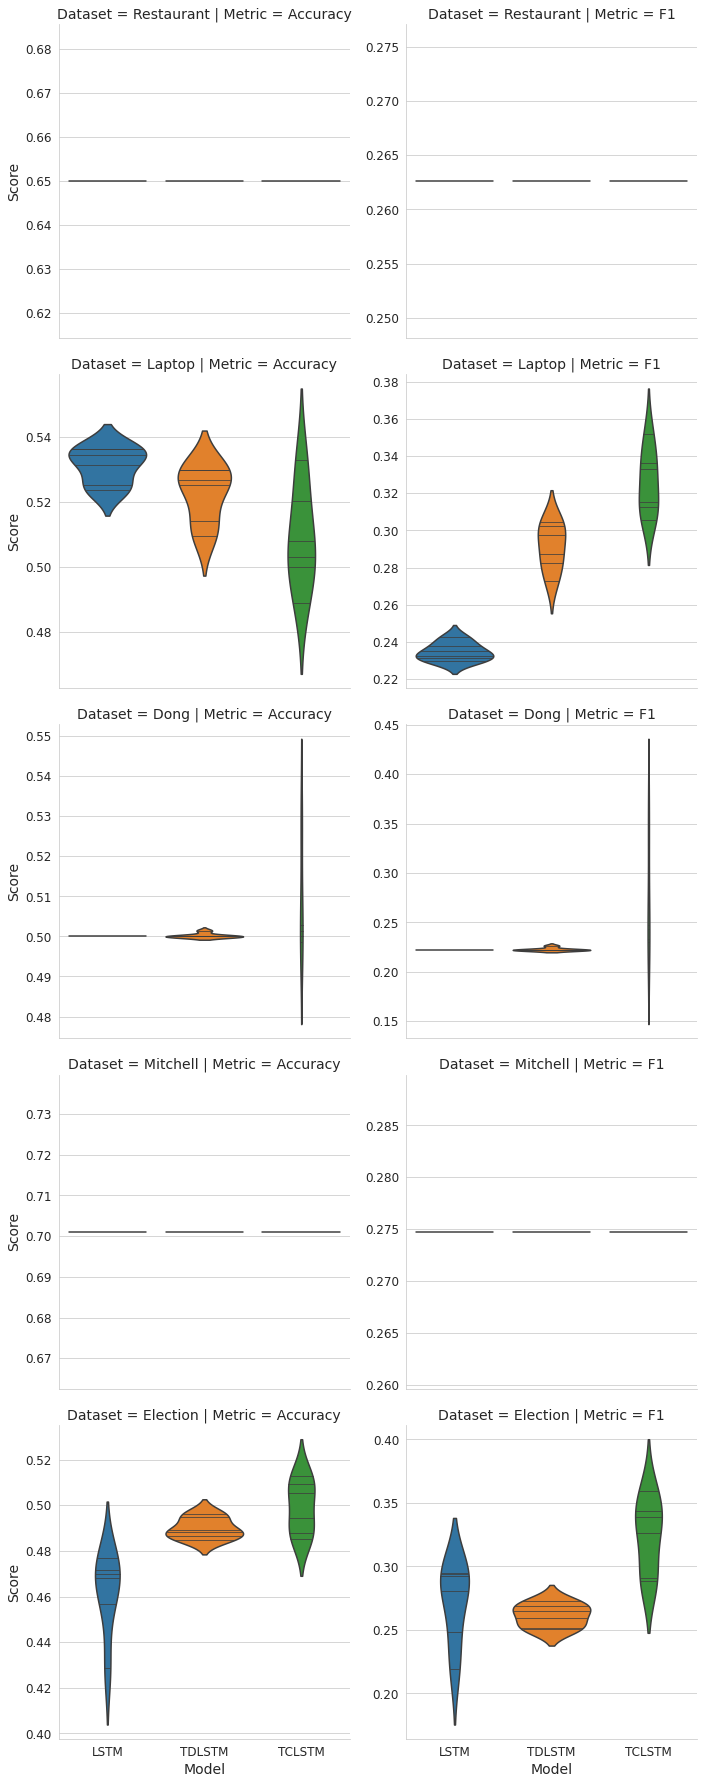

In [33]:
image_dir = config.IMAGES_DIR / 'Mass Evaluation Small Dataset'
image_dir.mkdir(parents=True, exist_ok=True)

lstm_results_df = result_df.copy(deep=True)
lstm_results_df = lstm_results_df[lstm_results_df['Model'].isin(lstm_model_names)]
lstm_results_df = pd.melt(lstm_results_df, id_vars=['Dataset', 'Model'], 
                          value_vars=['Accuracy', 'F1'], var_name='Metric', 
                          value_name='Score')
lstm_test_ax = sns.catplot(x='Model', y='Score',  inner='stick',
                           col='Metric', data=lstm_results_df, 
                           kind='violin', row='Dataset', 
                           sharey=False) 
image_fp = str(Path(image_dir, 'LSTM_Test_ACC_F1.pdf').resolve())
lstm_test_ax.savefig(image_fp, bbox_inches='tight')
lstm_test_ax

Below we show if the results are significantly different between the models

In [56]:
# Finding mapping between the np and lstm true values

mapped_lstm_true_values = []
mapped_lstm_predictions = []
for true_values_index, true_values in enumerate(np_true_values):
    true_values = np.array(true_values)
    np_mapped_values = np.unique(true_values).tolist()
    
    lstm_to_np_mapper = {}
    lstm_values = lstm_true_values[true_values_index].tolist()
    for np_mapped_value in np_mapped_values:
        lstm_to_np_mapper[lstm_values[true_values.tolist().index(np_mapped_value)]] = np_mapped_value
    
    mapped_lstm_true_values.append(np.array([lstm_to_np_mapper[value] for value in lstm_values]))
    mapped_model_predictions = []
    for model_predictions in lstm_predictions[true_values_index].T.tolist():
        mapped_model_predictions.append([lstm_to_np_mapper[value] for value in model_predictions])
    mapped_lstm_predictions.append(np.array(mapped_model_predictions).T)

# Join the NP and LSTM predictions together
all_predictions = []
for prediction_index, np_prediction in enumerate(np_predictions):
    all_predictions.append(np.concatenate([np_prediction, 
                                           mapped_lstm_predictions[prediction_index]], 1))

# Get the bootstrap values for each dataset for each model
# The arrays are of shape (number_bootstraps, number models)
accuracy_bootstrap: List[np.ndarray] = []
f1_bootstrap: List[np.ndarray] = []
for dataset_index, np_test_dataset in enumerate(np_test_datasets):
    if np_test_dataset.name == 'YouTuBean':
        continue
    true_values = np_true_values[dataset_index]
    predictions = all_predictions[dataset_index]
    
    accuracy_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                                     predictions, 
                                                     accuracy_score))
    f1_bootstrap.append(thesis_stats.bootstrap(true_values, 
                                               predictions, 
                                               f1_score, 
                                               average='macro'))

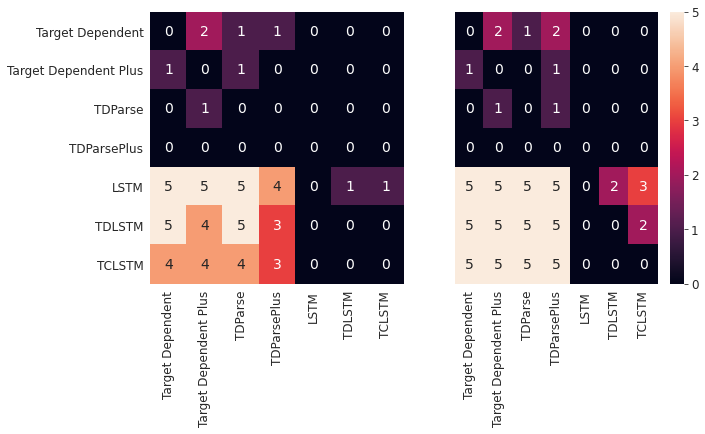

In [58]:
fig, sig_test_axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
sns.heatmap(get_sig_better_worse_models(accuracy_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[0], cbar=False)
sns.heatmap(get_sig_better_worse_models(f1_bootstrap, bootstrap_model_names), annot=True, ax=sig_test_axs[1])
image_fp = str(Path(image_dir, 'Small_Sig_Test.pdf').resolve())
fig.savefig(image_fp, bbox_inches='tight')

### Validation scores for the LSTM models
For completeness the scores from the validation data are shown below. This is only applicable for the LSTM models as the NP models use the whole training data and do not require validation data.

Accuracy results:

In [60]:
accuracy_index_order = list(itertools.product(['Accuracy'], lstm_model_names))
validation_result_df = pd.DataFrame({'Model': lstm_validation_model_names,
                                     'Dataset': lstm_validation_dataset_names,
                                     'Accuracy': lstm_validation_accuracies,
                                     'F1': lstm_validation_f1s})
accuracy_result_df = (pd.pivot_table(data=validation_result_df, 
                                     values=['Accuracy'], 
                                     index='Dataset', 
                                     columns='Model', 
                                     aggfunc=np.mean)*100).round(2).T
result_averages = validation_result_df.groupby(['Model', 'Dataset']).mean()\
                                      .groupby('Model').mean()
result_averages = result_averages.reindex(lstm_model_names)
accuracy_result_df = accuracy_result_df.reindex(accuracy_index_order)
# Add the mean column
accuracy_result_averages = (result_averages['Accuracy'] * 100).round(2)
accuracy_result_averages.index = pd.MultiIndex.from_tuples(accuracy_index_order)
accuracy_result_df['Mean'] = accuracy_result_averages
accuracy_result_df


Dataset           Dong  Election  Laptop  Mitchell  Restaurant   Mean
         Model                                                       
Accuracy LSTM    48.65     43.81   43.64     64.49       66.17  53.35
         TDLSTM  48.65     43.22   44.24     64.49       66.17  53.35
         TCLSTM  47.90     45.28   46.67     64.49       66.17  54.10

F1 results:

In [61]:
f1_index_order = list(itertools.product(['F1'], lstm_model_names))
f1_result_df = (pd.pivot_table(data=validation_result_df, 
                               values=['F1'], 
                               index='Dataset', 
                               columns='Model', 
                               aggfunc=np.mean)*100).round(2).T
f1_result_df = f1_result_df.reindex(f1_index_order)
# Add the mean column
f1_result_averages = (result_averages['F1'] * 100).round(2)
f1_result_averages.index = pd.MultiIndex.from_tuples(f1_index_order)
f1_result_df['Mean'] = f1_result_averages
f1_result_df

Dataset     Dong  Election  Laptop  Mitchell  Restaurant   Mean
   Model                                                       
F1 LSTM    21.82     27.00   20.69     26.14       26.55  24.44
   TDLSTM  21.82     24.84   26.02     26.14       26.55  25.07
   TCLSTM  25.14     30.92   31.44     26.14       26.55  28.04

Distribution of the results

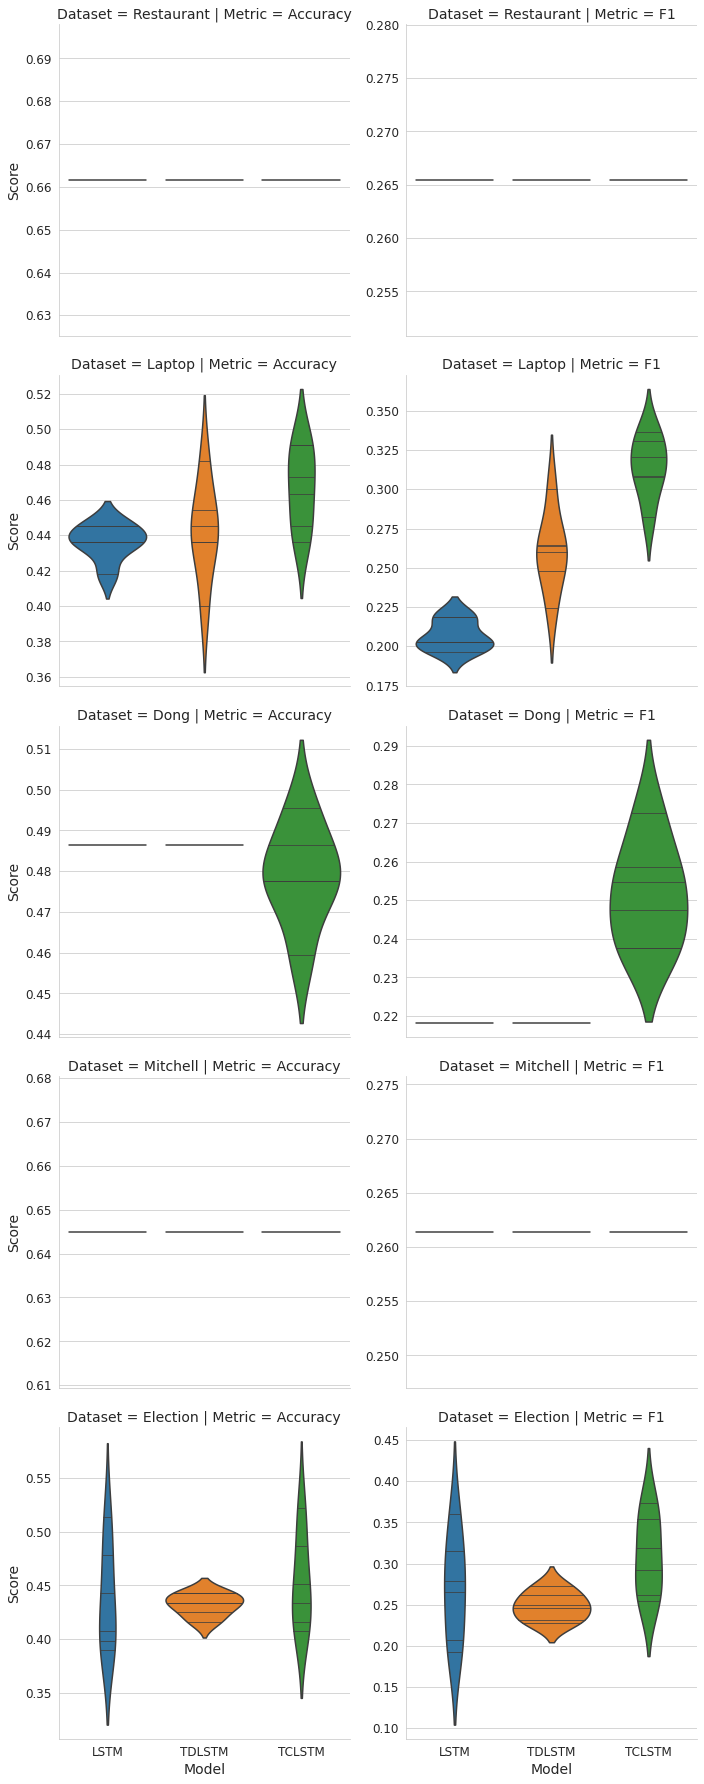

In [62]:
image_dir = config.IMAGES_DIR / 'Mass Evaluation Small Dataset'
image_dir.mkdir(parents=True, exist_ok=True)

lstm_results_df = pd.melt(validation_result_df, id_vars=['Dataset', 'Model'], 
                          value_vars=['Accuracy', 'F1'], var_name='Metric', 
                          value_name='Score')
lstm_test_ax = sns.catplot(x='Model', y='Score',  inner='stick',
                           col='Metric', data=lstm_results_df, 
                           kind='violin', row='Dataset', 
                           sharey=False) 
image_fp = str(Path(image_dir, 'LSTM_Validation_ACC_F1.pdf').resolve())
lstm_test_ax.savefig(image_fp, bbox_inches='tight')
lstm_test_ax